# Analýza shromážděných účastnických dat pro AmKon 2023 prostřednictvím systému AmKonApp
*autor: Martin Gráf*

*\*K analýze byla využita data z databáze AmKonApp k datu 17.9.2023.*

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import plotly.graph_objects as gp

In [2]:
def removeSensitiveColumns(d: pd.DataFrame):
    d.drop('Číslo průkazu',axis='columns', inplace=True, errors='ignore')

In [3]:
def removeAdminsAndOrgs(d: pd.DataFrame) -> pd.DataFrame:
    attendees = d.loc[d['Přístupová práva'].isin(['Účastník', 'Přihlášený'])]
    # loggedIn = d[d['Přístupová práva'] == ]
    return attendees

In [4]:
def constructRegistrationsWithUserFields(users: pd.DataFrame, registrations: pd.DataFrame) -> pd.DataFrame:
    amendedRegistrations = registrations
    amendedRegistrations['Pohlaví'] = 'Jiné'
    amendedRegistrations['Účasti simulací'] = 0
    amendedRegistrations['Přístupová práva'] = np.nan
    for reg in amendedRegistrations.index:
        currentItem = amendedRegistrations.loc[reg]
        correspondingUser = users.loc[users['Id'] == currentItem['Id']].iloc[0]
        amendedRegistrations.at[reg, 'Pohlaví'] = correspondingUser['Pohlaví']
        amendedRegistrations.at[reg, 'Přístupová práva'] = correspondingUser['Přístupová práva']
        amendedRegistrations.at[reg, 'Účasti simulací'] = currentItem['Počet účastí jiných simulací'] + currentItem['Počet předchozích účastí']
    return amendedRegistrations

In [5]:
def constructTransactionsWithUserAndRegFields(users: pd.DataFrame, registrations: pd.DataFrame, transactions: pd.DataFrame) -> pd.DataFrame:
    amendedTransactions = transactions

    amendedTransactions['Pohlaví odesílatele'] = np.nan
    amendedTransactions['Strana odesílatele'] = np.nan
    amendedTransactions['Typ pozice odesílatele'] = np.nan
    amendedTransactions['Frakce odesílatele'] = np.nan
    amendedTransactions['Vzdělání odesílatele'] = np.nan
    amendedTransactions['Politická aktivita odesílatele'] = np.nan
    amendedTransactions['Účasti simulací odesílatele'] = np.nan

    amendedTransactions['Pohlaví příjemce'] = np.nan
    amendedTransactions['Strana příjemce'] = np.nan
    amendedTransactions['Typ pozice příjemce'] = np.nan
    amendedTransactions['Frakce příjemce'] = np.nan
    amendedTransactions['Vzdělání příjemce'] = np.nan
    amendedTransactions['Politická aktivita příjemce'] = np.nan
    amendedTransactions['Účasti simulací příjemce'] = np.nan

    for tran in amendedTransactions.index:
        currentItem = amendedTransactions.loc[tran]

        correspondingSender = users.loc[users['Id'] == currentItem['Provedl']]
        correspondingReciever = users.loc[users['Jméno'] == currentItem['Příjemce']]

        if len(correspondingSender) > 0:
            correspondingSender = correspondingSender.iloc[0]

            amendedTransactions.at[tran, 'Pohlaví odesílatele'] = correspondingSender['Pohlaví']
            amendedTransactions.at[tran, 'Strana odesílatele'] = correspondingSender['Strana']
            amendedTransactions.at[tran, 'Frakce odesílatele'] = correspondingSender['Frakce']
            if not pd.isna(correspondingSender['Pozice']):
                if correspondingSender['Pozice'].startswith('Lobista'):
                    amendedTransactions.at[tran, 'Typ pozice odesílatele'] = 'Lobby'
                elif correspondingSender['Pozice'].startswith('Poslanec'):
                    amendedTransactions.at[tran, 'Typ pozice odesílatele'] = 'House'
                elif correspondingSender['Pozice'].startswith('Senátor'):
                    amendedTransactions.at[tran, 'Typ pozice odesílatele'] = 'Senate'
            
            correspondingSenderReg = registrations.loc[correspondingSender['Id'] == registrations['Id']]

            if len(correspondingSenderReg) > 0:
                correspondingSenderReg = correspondingSenderReg.iloc[0]
                amendedTransactions.at[tran, 'Vzdělání odesílatele'] = correspondingSenderReg['Školní rok']
                amendedTransactions.at[tran, 'Politická aktivita odesílatele'] = correspondingSenderReg['Člen politické strany']
                amendedTransactions.at[tran, 'Účasti simulací odesílatele'] = correspondingSenderReg['Počet účastí jiných simulací']
                + correspondingSenderReg['Počet předchozích účastí']

        if len(correspondingReciever) > 0:
            correspondingReciever = correspondingReciever.iloc[0]
            #correspondingRecieverReg = registrations.loc[correspondingReciever['Id'] == registrations['Id']].iloc[0]
            amendedTransactions.at[tran, 'Pohlaví příjemce'] = correspondingReciever['Pohlaví']
            amendedTransactions.at[tran, 'Strana příjemce'] = correspondingReciever['Strana']
            amendedTransactions.at[tran, 'Frakce příjemce'] = correspondingReciever['Frakce']
            if not pd.isna(correspondingReciever['Pozice']):
                if correspondingReciever['Pozice'].startswith('Lobista'):
                    amendedTransactions.at[tran, 'Typ pozice příjemce'] = 'Lobby'
                elif correspondingReciever['Pozice'].startswith('Poslanec'):
                    amendedTransactions.at[tran, 'Typ pozice příjemce'] = 'House'
                elif correspondingReciever['Pozice'].startswith('Senátor'):
                    amendedTransactions.at[tran, 'Typ pozice příjemce'] = 'Senate'

            correspondingRecieverReg = registrations.loc[correspondingReciever['Id'] == registrations['Id']]

            if len(correspondingRecieverReg) > 0:
                correspondingRecieverReg = correspondingRecieverReg.iloc[0]
                amendedTransactions.at[tran, 'Vzdělání příjemce'] = correspondingRecieverReg['Školní rok']
                amendedTransactions.at[tran, 'Politická aktivita příjemce'] = correspondingRecieverReg['Člen politické strany']
                amendedTransactions.at[tran, 'Účasti simulací příjemce'] = correspondingRecieverReg['Počet účastí jiných simulací']
                + correspondingSenderReg['Počet předchozích účastí']

    return amendedTransactions

In [6]:
def constructPyramidPercentDataframe(originData: pd.DataFrame, categories: list, categoricalColumn: str, binaryColumn: str, binary1: str, binary2: str) -> pd.DataFrame:
    set1 = originData[originData[binaryColumn] == binary1]
    set2 = originData[originData[binaryColumn] == binary2]
    distribution = pd.DataFrame({categoricalColumn: categories, 
                                    binary1: [set1[set1[categoricalColumn] == i].shape[0] for i in categories],
                                    binary2: [set2[set2[categoricalColumn] == i].shape[0] for i in categories]})
    sum2 = distribution[binary2].sum()
    sum1 = distribution[binary1].sum()
    if sum2 > 0:
        set2Percent = 100/sum2
    else:
        set2Percent = 1

    if sum1 > 0:
        set1Percent = 100/sum1
    else:
        set1Percent = 1

    for i in range(len(distribution)):
        distribution[binary1][i] = distribution[binary1][i]*set1Percent
        distribution[binary2][i] = distribution[binary2][i]*set2Percent
    distribution[binary2] = distribution[binary2] * (-1)
    return distribution

In [7]:
users = pd.read_csv('data/2023/export.csv')
registrations = pd.read_csv('data/2023/registrace.csv')
transactions = pd.read_csv('data/2023/transakce.csv')

warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
genders = ['Muž', 'Žena', 'Jiné']
schoolVals = ['2. ročník SŠ a nižší', '3. ročník SŠ', '4. ročník SŠ', 'bakalářské studium', 'magisterské studium']
congressBodies = ['Government', 'TCK', 'Lobby', 'Senate', 'House']
committees = ['Výbor pro justici', 'Výbor pro ozbrojené složky', 'Výbor pro zahraniční vztahy', 'Výbor pro národní bezpečnost', 
 'Výbor pro klimatickou krizi', 'Výbor pro energetiku a hospodářství', 'Výbor pro biotechnologie a výzkum', 'Výbor pro sociální služby']

Z celkem 139 přijatých účastníků bylo 90 mužů a 48 žen, spolu s 1 příslušníkem jiného pohlaví.


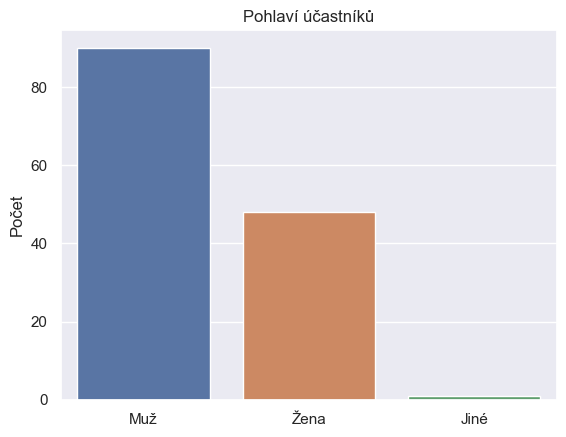

In [9]:
removeSensitiveColumns(users)
nonOrgs = removeAdminsAndOrgs(users)
sns.set(font_scale=1)
user_hist = sns.countplot(x=nonOrgs['Pohlaví'], data=nonOrgs, order=genders)
print('Z celkem {} přijatých účastníků bylo {} mužů a {} žen, spolu s {} příslušníkem jiného pohlaví.'
      .format(nonOrgs[nonOrgs['Pohlaví'].isin(genders)].shape[0], nonOrgs[nonOrgs['Pohlaví'] == 'Muž'].shape[0], nonOrgs[nonOrgs['Pohlaví'] == 'Žena'].shape[0], 
              nonOrgs[nonOrgs['Pohlaví'] == 'Jiné'].shape[0]))
plt.title('Pohlaví účastníků')
plt.ylabel('Počet')
plt.xlabel('')
plt.show(user_hist)


Vzhledem k minimálnímu množství příslušníků jiného pohlaví budou vynecháni při porovnávání vlastností jednotlivých skupin podle pohlaví, budou ovšem zahrnuti v jiných metrikách.

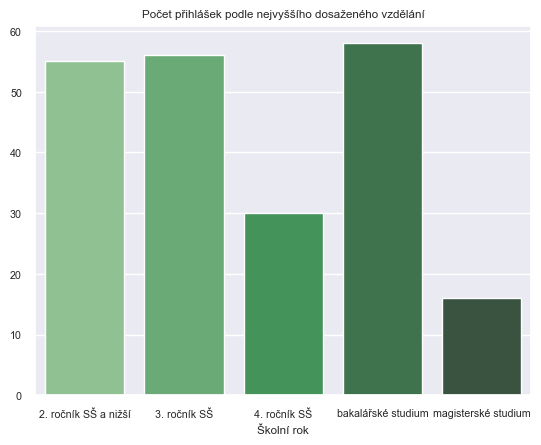

                               Id  Počet předchozích účastí  \
2    1yPRGEh6zRSFVzpIHngHTIIlt2J3                         0   
11   d3isorGybNgpwyNXaWiZ7oumRV82                         0   
16   bywr76hq5lZV9SkydwgYQYCTwLG3                         2   
24   mVoSKlZ2QzWbNMxP1SmDbzbmIJ22                         1   
25   3XBP4g8idlPNFxiOrVqsLagmKZp1                         2   
..                            ...                       ...   
259  roQocKj7iIXPWQcfZa31swwMDv83                         0   
260  pVtQAsVWCPWKiqoAEMGq9c6rj3r2                         0   
261  zFJbn969yjMdZstFizCJ29vAiKX2                         1   
262  1VjtcjZE7xMQJgsrVPcrUye2Up43                         2   
263  l9xCDVUGLIWqpO3XZV73APP2nBY2                         7   

     Počet účastí jiných simulací           Školní rok Člen politické strany  \
2                               0   bakalářské studium                   ANO   
11                              1   bakalářské studium                    NE   
16 

In [10]:
pairedRegs = constructRegistrationsWithUserFields(users=nonOrgs, registrations=registrations)
sns.set(font_scale=0.7)
fig = sns.countplot(x=pairedRegs['Školní rok'], order=schoolVals, data=pairedRegs, palette="Greens_d")
plt.ylabel("")
plt.title("Počet přihlášek podle nejvyššího dosaženého vzdělání")
plt.show(fig)
print(pairedRegs[pairedRegs['Školní rok'].isin(['bakalářské studium', 'magisterské studium'])])

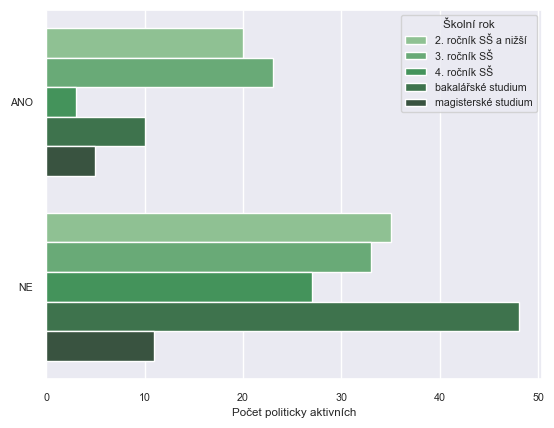

In [11]:
fig = sns.countplot(y=pairedRegs['Člen politické strany'], data=pairedRegs, hue=pairedRegs['Školní rok'], hue_order=schoolVals, palette="Greens_d")
plt.ylabel("")
plt.xlabel("Počet politicky aktivních")
plt.show(fig)

In [12]:
schoolDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=schoolVals, categoricalColumn='Školní rok', binaryColumn='Pohlaví', binary1='Muž', binary2='Žena')

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2371379105.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distribution[binary1][i] = distribution[binary1][i]*set1Percent
C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2371379105.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distribution[binary2][i] = distribution[binary2][i]*set2Percent


In [13]:
fig = gp.Figure()

fig.add_trace(gp.Bar(y= schoolDistribution['Školní rok'], x = schoolDistribution['Muž'], 
                     name = 'Muži', 
                     orientation = 'h'))

fig.add_trace(gp.Bar(y = schoolDistribution['Školní rok'], x = schoolDistribution['Žena'],
                     name = 'Ženy', orientation = 'h'))

fig.update_layout(title = 'Rozdělení vzdělání podle pohlaví',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-30, -20, -10,
                                          0, 10, 20, 30],
                                
                              ticktext = ['30%', '20%', '10%', '0%', 
                                          '10%', '20%', '30%'],
                                
                              title_font_size = 14)
                 )
  
fig.show()

In [14]:
schoolPoliticsDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=genders, categoricalColumn='Pohlaví', binaryColumn='Člen politické strany', binary1='ANO', binary2='NE')

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2371379105.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2371379105.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
fig = gp.Figure()
fig.add_trace(gp.Bar(y= schoolPoliticsDistribution['Pohlaví'], x = schoolPoliticsDistribution['ANO'], 
                     name = 'Politicky aktivní', 
                     orientation = 'h'))
fig.add_trace(gp.Bar(y = schoolPoliticsDistribution['Pohlaví'], x = schoolPoliticsDistribution['NE'],
                     name = 'Politicky neaktivní', orientation = 'h'))
fig.update_layout(title = 'Rozdělení pohlaví podle členství v politických stranách',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-80, -60, -30, -10,
                                          0, 10, 30, 60, 80],
                                
                            ticktext = ['80%', '60%', '30%', '10%', '0%', 
                                          '10%', '30%', '60%', '80%'],
                            title_font_size = 14)
                 )
fig.show()

In [16]:
preferenceDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=congressBodies, categoricalColumn='Preferovaná odnož', binaryColumn='Pohlaví', binary1='Muž', binary2='Žena')

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2371379105.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2371379105.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
fig = gp.Figure()
fig.add_trace(gp.Bar(y= preferenceDistribution['Preferovaná odnož'], x = preferenceDistribution['Muž'], 
                     name = 'Muži', 
                     orientation = 'h'))
fig.add_trace(gp.Bar(y = preferenceDistribution['Preferovaná odnož'], x = preferenceDistribution['Žena'],
                     name = 'Ženy', orientation = 'h'))
fig.update_layout(title = 'Rozdělení preferencí rolí podle pohlaví',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-30, -20, -10,
                                          0, 10, 20, 30],
                            ticktext = ['30%', '20%', '10%', '0%', 
                                          '10%', '20%', '30%'],
                            title="Ženy/Muži",
                            title_font_size = 14)
                 )
fig.show()

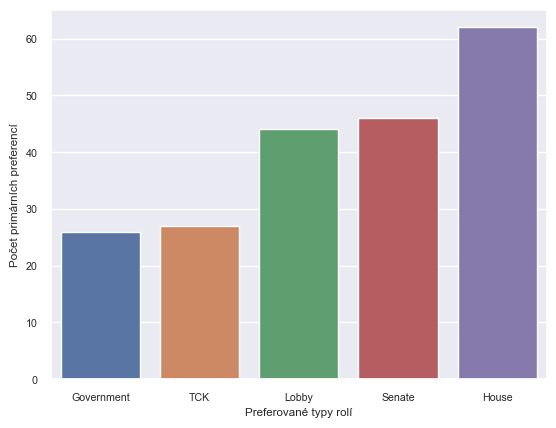

In [18]:
sns.set(font_scale=0.7)
fig = sns.countplot(x=pairedRegs['Preferovaná odnož'], order=congressBodies, data=pairedRegs)
plt.ylabel("Počet primárních preferencí")
plt.xlabel("Preferované typy rolí")
plt.show(fig)

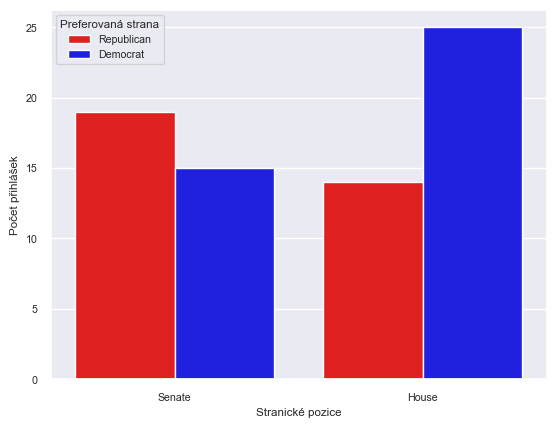

In [19]:
partisianPreferences = pairedRegs[pairedRegs['Preferovaná odnož'].isin(['House', 'Senate'])]
fig = sns.countplot(x=partisianPreferences['Preferovaná odnož'], data=partisianPreferences, hue=partisianPreferences['Preferovaná strana'], palette=['Red','Blue'])
plt.ylabel("Počet přihlášek")
plt.xlabel("Stranické pozice")
plt.show(fig)

In [20]:
partisianDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=genders, categoricalColumn='Pohlaví', binaryColumn='Preferovaná strana', binary1='Republican', binary2='Democrat')

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2371379105.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2371379105.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
fig = gp.Figure()
fig.add_trace(gp.Bar(y= partisianDistribution['Pohlaví'], x = partisianDistribution['Democrat'], 
                     name = 'Demokraté', 
                     orientation = 'h'))
fig.add_trace(gp.Bar(y = partisianDistribution['Pohlaví'], x = partisianDistribution['Republican'],
                     name = 'Republikáni', orientation = 'h'))
fig.update_layout(title = 'Rozdělení stranických preferencí podle pohlaví',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-60, -30, -10,
                                          0, 10, 30, 60],
                              ticktext = ['60%', '30%', '10%', '0%', 
                                          '10%', '30%', '60%'],
                              title_font_size = 14)
                 )
fig.show()

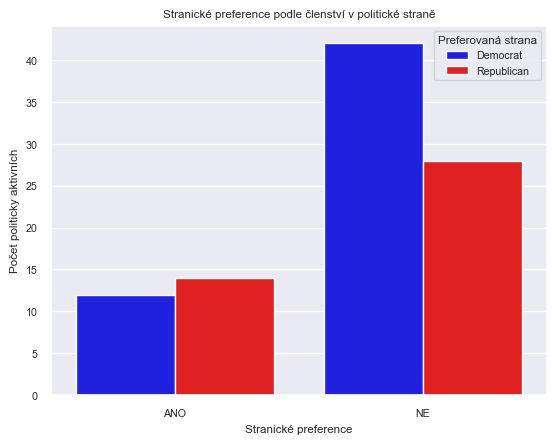

In [22]:
fig = sns.countplot(x=pairedRegs['Člen politické strany'], data=pairedRegs, hue=pairedRegs['Preferovaná strana'], palette=['Blue', 'Red'])
plt.ylabel("Počet politicky aktivních")
plt.xlabel("Stranické preference")
plt.title("Stranické preference podle členství v politické straně")
plt.show(fig)

In [23]:
partisianDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=schoolVals, categoricalColumn='Školní rok', binaryColumn='Preferovaná strana', binary1='Republican', binary2='Democrat')

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2371379105.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2371379105.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
fig = gp.Figure()
fig.add_trace(gp.Bar(y= partisianDistribution['Školní rok'], x = partisianDistribution['Democrat'], 
                     name = 'Demokraté', 
                     orientation = 'h'))
fig.add_trace(gp.Bar(y = partisianDistribution['Školní rok'], x = partisianDistribution['Republican'],
                     name = 'Republikáni', orientation = 'h'))
fig.update_layout(title = 'Rozdělení stranických preferencí podle vzdělání',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-40, -30, -20, -10,
                                          0, 10, 20, 30, 40],
                              ticktext = ['40%', '30%', '20%', '10%', '0%', 
                                          '10%', '20%', '30%', '40%'],
                              title_font_size = 14)
                 )
fig.show()

In [25]:
lowerEducation = pairedRegs[pairedRegs['Školní rok'] == '2. ročník SŠ a nižší']
thirdEducation = pairedRegs[pairedRegs['Školní rok'] == '3. ročník SŠ']
fourthEducation = pairedRegs[pairedRegs['Školní rok'] == '4. ročník SŠ']
bachelorEducation = pairedRegs[pairedRegs['Školní rok'] == 'bakalářské studium']
masterEducation = pairedRegs[pairedRegs['Školní rok'] == 'magisterské studium']

lowerEducationDem = lowerEducation[lowerEducation['Preferovaná strana'] == 'Democrat']
thirdEducationDem = thirdEducation[thirdEducation['Preferovaná strana'] == 'Democrat']
fourthEducationDem = fourthEducation[fourthEducation['Preferovaná strana'] == 'Democrat']
bachelorEducationDem = bachelorEducation[bachelorEducation['Preferovaná strana'] == 'Democrat']
masterEducationDem = masterEducation[masterEducation['Preferovaná strana'] == 'Democrat']

lowerEducationRep = lowerEducation[lowerEducation['Preferovaná strana'] == 'Republican']
thirdEducationRep = thirdEducation[thirdEducation['Preferovaná strana'] == 'Republican']
fourthEducationRep = fourthEducation[fourthEducation['Preferovaná strana'] == 'Republican']
bachelorEducationRep = bachelorEducation[bachelorEducation['Preferovaná strana'] == 'Republican']
masterEducationRep = masterEducation[masterEducation['Preferovaná strana'] == 'Republican']

In [26]:
partisianEducation = pd.DataFrame({
    'Vzdělání': ['2. ročník SŠ a nižší', '3. ročník SŠ', '4. ročník SŠ', 'bakalářské studium', 'magisterské studium'],
    'Demokraté': [(len(lowerEducationDem)/len(lowerEducation))*100,
                       (len(thirdEducationDem)/len(thirdEducation))*100,
                       (len(fourthEducationDem)/len(fourthEducation))*100,
                       (len(bachelorEducationDem)/len(bachelorEducation))*100,
                       (len(masterEducationDem)/len(masterEducation))*100],
    'Republikáni': [(len(lowerEducationRep)/len(lowerEducation))*100,
                       (len(thirdEducationRep)/len(thirdEducation))*100,
                       (len(fourthEducationRep)/len(fourthEducation))*100,
                       (len(bachelorEducationRep)/len(bachelorEducation))*100,
                       (len(masterEducationRep)/len(masterEducation))*100],
    'Jiné': [((len(lowerEducation) - (len(lowerEducationRep) + len(lowerEducationDem)))/len(lowerEducation))*100,
                       ((len(thirdEducation) - (len(thirdEducationRep) + len(thirdEducationDem)))/len(thirdEducation))*100,
                       ((len(fourthEducation) - (len(fourthEducationRep) + len(fourthEducationDem)))/len(fourthEducation))*100,
                       ((len(bachelorEducation) - (len(bachelorEducationRep) + len(bachelorEducationDem)))/len(bachelorEducation))*100,
                       ((len(masterEducation) - (len(masterEducationRep) + len(masterEducationDem)))/len(masterEducation))*100]
})

In [27]:
partisianEducation

,Vzdělání,Demokraté,Republikáni,Jiné
0,2. ročník SŠ a nižší,25.454545,30.909091,43.636364
1,3. ročník SŠ,23.214286,23.214286,53.571429
2,4. ročník SŠ,20.000000,16.666667,63.333333
3,bakalářské studium,27.586207,8.620690,63.793103
4,magisterské studium,31.250000,6.250000,62.500000


C:\Users\margr\AppData\Local\Temp\ipykernel_17940\1029213649.py:13: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



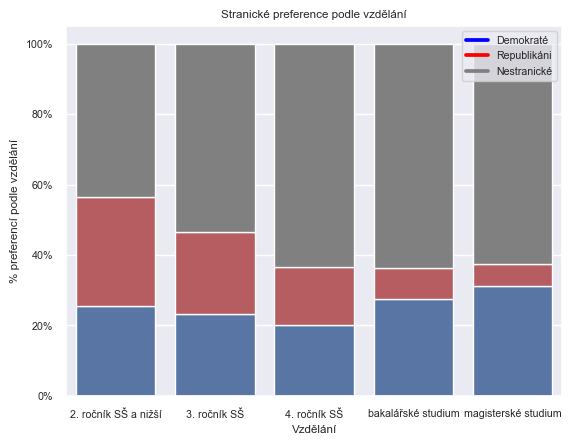

In [28]:
ax = plt.subplots()
 
# plotting columns
ax = sns.barplot(x=partisianEducation['Vzdělání'], y=partisianEducation['Demokraté'], color='b')
ax = sns.barplot(x=partisianEducation['Vzdělání'], y=partisianEducation['Republikáni'], bottom=partisianEducation['Demokraté'], color='r')
ax = sns.barplot(x=partisianEducation['Vzdělání'], y=partisianEducation['Jiné'], bottom=partisianEducation['Demokraté'] + partisianEducation['Republikáni'], color='gray')
 
# visualizing illustration
leg = plt.legend(["Demokraté", "Republikáni", "Nestranické"])
leg.legend_handles[0].set_color('blue')
leg.legend_handles[1].set_color('red')
leg.legend_handles[2].set_color('gray')
ax.set_yticklabels(['{:.0f}'.format(x) + '%' for x in ax.get_yticks()])
plt.ylabel("% preferencí podle vzdělání")
plt.title("Stranické preference podle vzdělání")
plt.show()

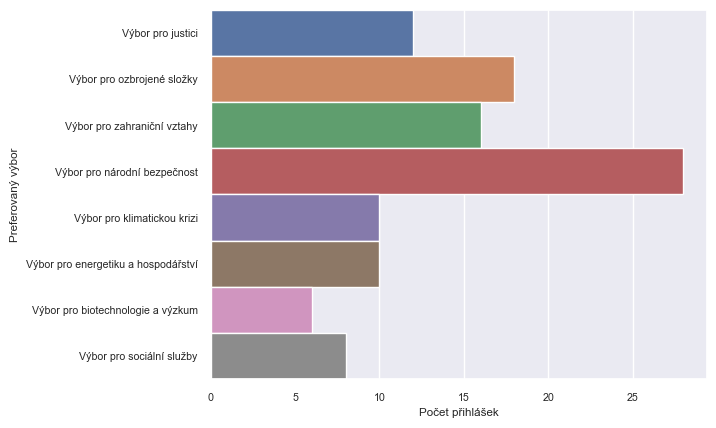

In [29]:
sns.set(font_scale=0.7)
fig = sns.countplot(y=pairedRegs['Preferovaný výbor'], data=pairedRegs, width=1)
plt.ylabel("Preferovaný výbor")
plt.xlabel("Počet přihlášek")
plt.show(fig)

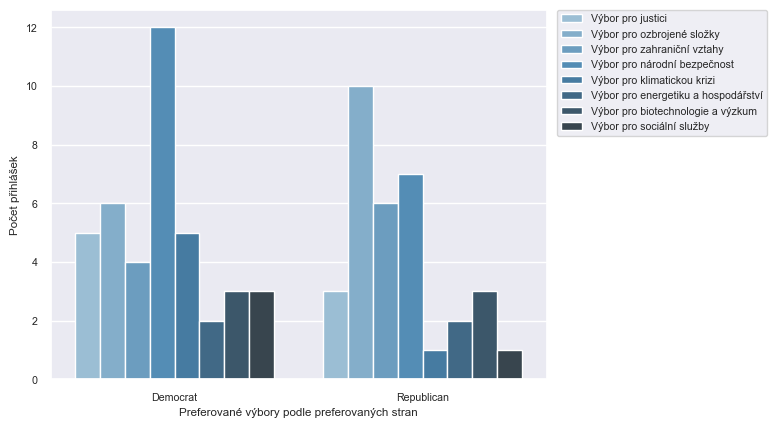

In [30]:
fig = sns.countplot(x=pairedRegs['Preferovaná strana'], data=pairedRegs, hue=pairedRegs['Preferovaný výbor'], palette="Blues_d")
plt.ylabel("Počet přihlášek")
plt.xlabel("Preferované výbory podle preferovaných stran")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show(fig)

In [31]:
committeeDistribution = constructPyramidPercentDataframe(originData=pairedRegs, categories=committees, categoricalColumn='Preferovaný výbor', binaryColumn='Pohlaví', binary1='Muž', binary2='Žena')

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2371379105.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2371379105.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
fig = gp.Figure()
fig.add_trace(gp.Bar(y= committeeDistribution['Preferovaný výbor'], x = committeeDistribution['Muž'], 
                     name = 'Muži', 
                     orientation = 'h'))
fig.add_trace(gp.Bar(y = committeeDistribution['Preferovaný výbor'], x = committeeDistribution['Žena'],
                     name = 'Ženy', orientation = 'h'))
fig.update_layout(title = 'Rozdělení výborových preferencí podle pohlaví',
                 title_font_size = 22, barmode = 'relative',
                 bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-40, -30, -20, -10,
                                          0, 10, 20, 30, 40],
                              ticktext = ['40%', '30%', '20%', '10%', '0%', 
                                          '10%', '20%', '30%', '40%'],
                              title_font_size = 14)
                 )
fig.show()

<Axes: >

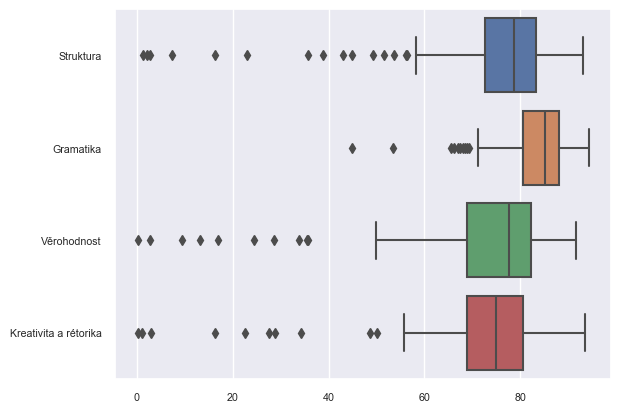

In [33]:
sns.boxplot(data=pairedRegs[["Struktura", "Gramatika", "Věrohodnost", "Kreativita a rétorika"]], orient="h")

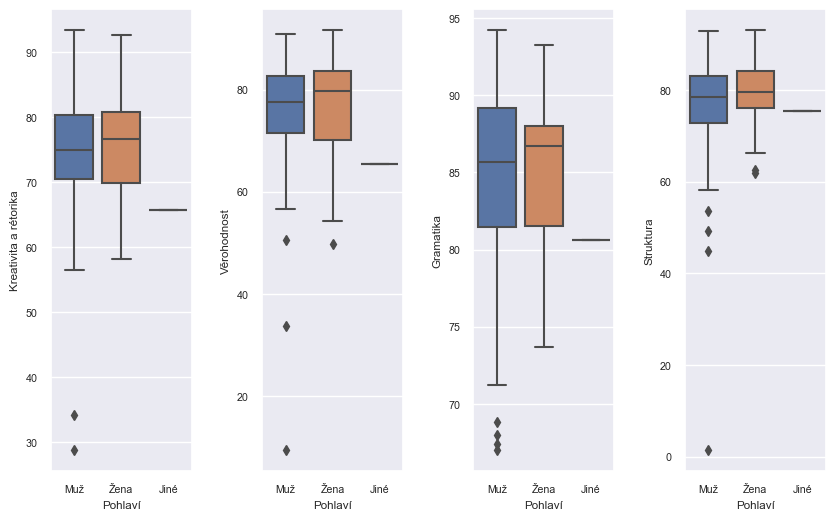

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(10, 6))
sns.boxplot(data=pairedRegs, x="Pohlaví", y="Kreativita a rétorika", ax=ax[0])
sns.boxplot(data=pairedRegs, x="Pohlaví", y="Věrohodnost", ax=ax[1])
sns.boxplot(data=pairedRegs, x="Pohlaví", y="Gramatika", ax=ax[2])
sns.boxplot(data=pairedRegs, x="Pohlaví", y="Struktura", ax=ax[3])
plt.subplots_adjust(wspace=0.5) 
plt.show()

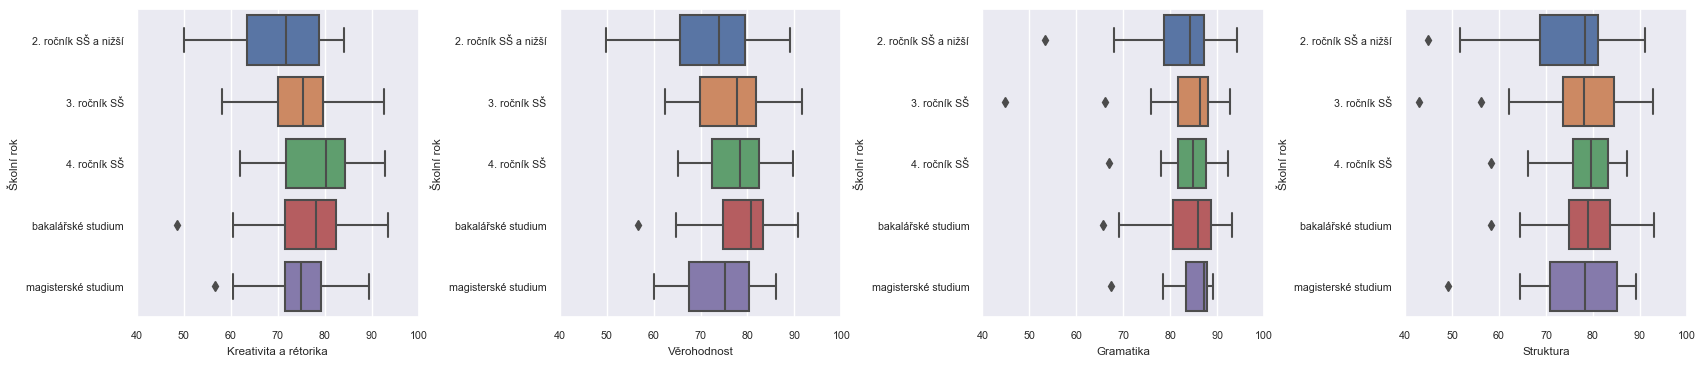

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
p = sns.boxplot(data=pairedRegs, y="Školní rok", x="Kreativita a rétorika", ax=ax[0], orient="h", order=schoolVals)
p.set(xlim = (40, 100))
p = sns.boxplot(data=pairedRegs, y="Školní rok", x="Věrohodnost", ax=ax[1], orient="h", order=schoolVals)
p.set(xlim = (40, 100))
p = sns.boxplot(data=pairedRegs, y="Školní rok", x="Gramatika", ax=ax[2], orient="h", order=schoolVals)
p.set(xlim = (40, 100))
p = sns.boxplot(data=pairedRegs, y="Školní rok", x="Struktura", ax=ax[3], orient="h", order=schoolVals)
p.set(xlim = (40, 100))
plt.subplots_adjust(wspace=0.5) 
plt.show()

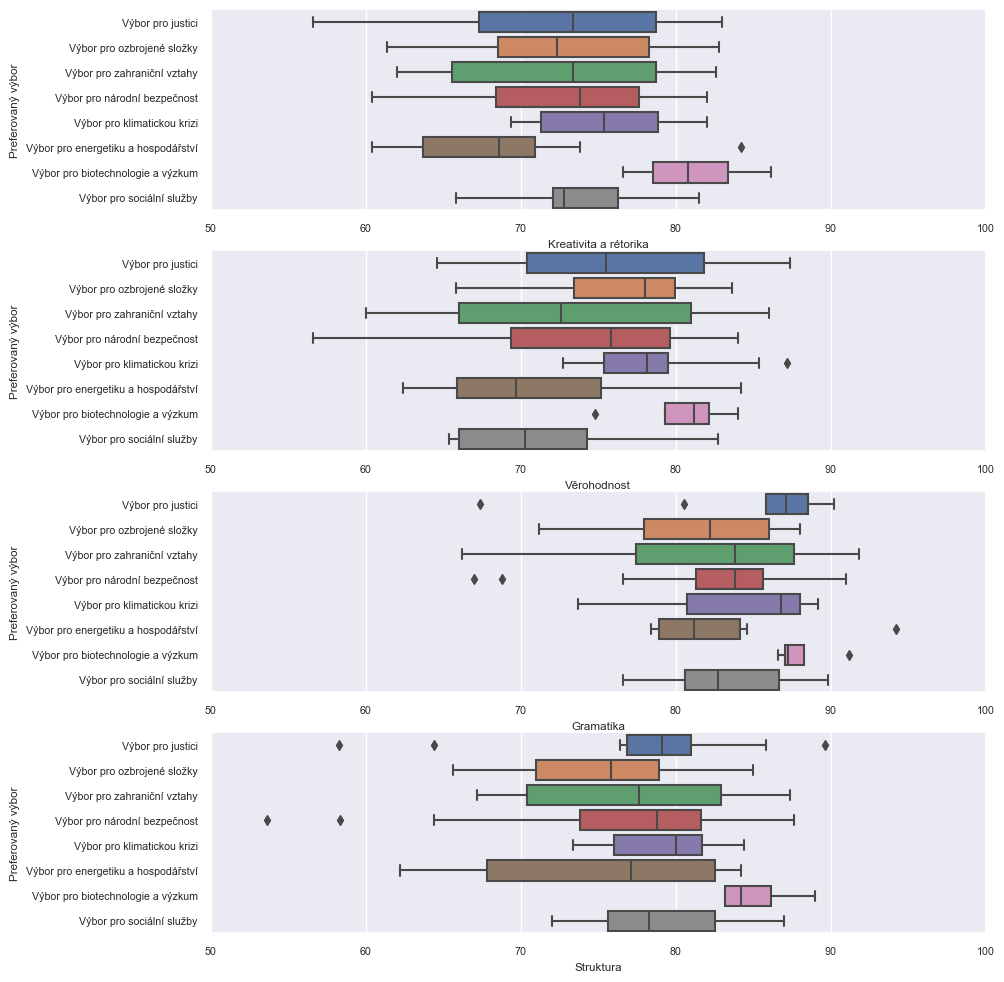

In [36]:
fig, ax = plt.subplots(4, 1, figsize=(10, 12))
p = sns.boxplot(data=pairedRegs, y="Preferovaný výbor", x="Kreativita a rétorika", ax=ax[0], orient="h")
p.set(xlim = (50, 100))
p = sns.boxplot(data=pairedRegs, y="Preferovaný výbor", x="Věrohodnost", ax=ax[1], orient="h")
p.set(xlim = (50, 100))
p = sns.boxplot(data=pairedRegs, y="Preferovaný výbor", x="Gramatika", ax=ax[2], orient="h")
p.set(xlim = (50, 100))
p = sns.boxplot(data=pairedRegs, y="Preferovaný výbor", x="Struktura", ax=ax[3], orient="h")
plt.subplots_adjust(wspace=0.5) 
p.set(xlim = (50, 100))
plt.show()

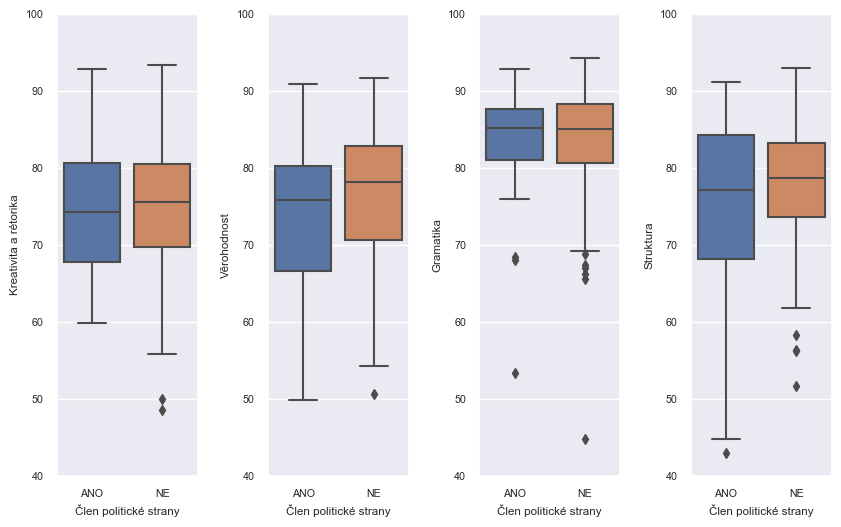

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(10, 6))
p = sns.boxplot(data=pairedRegs, x='Člen politické strany', y="Kreativita a rétorika", ax=ax[0])
p.set(ylim = (40, 100))
p = sns.boxplot(data=pairedRegs, x='Člen politické strany', y="Věrohodnost", ax=ax[1])
p.set(ylim = (40, 100))
p = sns.boxplot(data=pairedRegs, x='Člen politické strany', y="Gramatika", ax=ax[2])
p.set(ylim = (40, 100))
p = sns.boxplot(data=pairedRegs, x='Člen politické strany', y="Struktura", ax=ax[3])
p.set(ylim = (40, 100))
plt.subplots_adjust(wspace=0.5) 
plt.show()

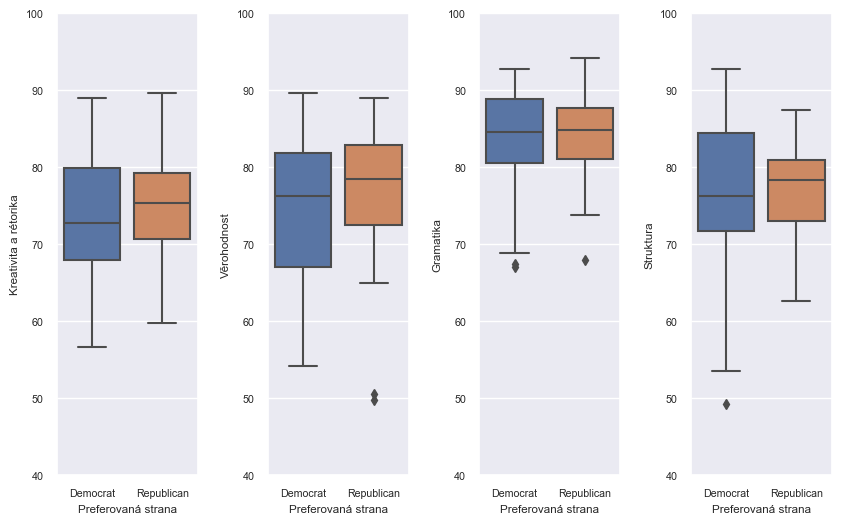

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(10, 6))
p = sns.boxplot(data=pairedRegs, x='Preferovaná strana', y="Kreativita a rétorika", ax=ax[0])
p.set(ylim = (40, 100))
p = sns.boxplot(data=pairedRegs, x='Preferovaná strana', y="Věrohodnost", ax=ax[1])
p.set(ylim = (40, 100))
p = sns.boxplot(data=pairedRegs, x='Preferovaná strana', y="Gramatika", ax=ax[2])
p.set(ylim = (40, 100))
p = sns.boxplot(data=pairedRegs, x='Preferovaná strana', y="Struktura", ax=ax[3])
p.set(ylim = (40, 100))
plt.subplots_adjust(wspace=0.5) 
plt.show()

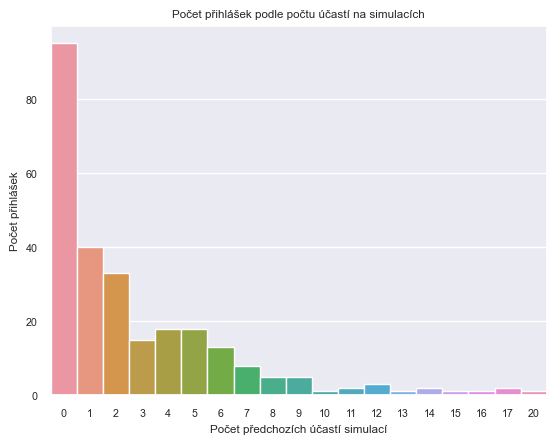

In [39]:
sns.set(font_scale=0.7)
fig = sns.countplot(x=pairedRegs['Účasti simulací'], data=pairedRegs, width=1)
plt.ylabel("Počet přihlášek")
plt.xlabel("Počet předchozích účastí simulací")
plt.title("Počet přihlášek podle počtu účastí na simulacích")
plt.show(fig)

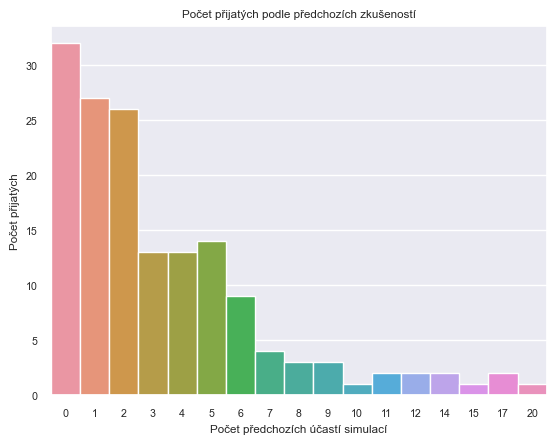

In [40]:
accepted = pairedRegs[pairedRegs['Přístupová práva'] == 'Účastník']
sns.set(font_scale=0.7)
fig = sns.countplot(x=accepted['Účasti simulací'], data=accepted, width=1)
plt.ylabel("Počet přijatých")
plt.xlabel("Počet předchozích účastí simulací")
plt.title('Počet přijatých podle předchozích zkušeností')
plt.show(fig)

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\222669858.py:17: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



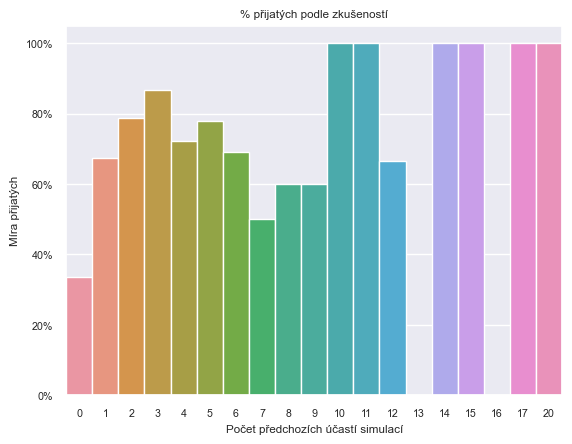

In [41]:
uniques = pairedRegs['Účasti simulací'].unique()
np.sort(uniques)
acceptanceRates = []
for i in uniques:
    current = pairedRegs[pairedRegs['Účasti simulací'] == i]
    currentAccepted = current[current['Přístupová práva'] == 'Účastník']
    acceptanceRates.append(len(currentAccepted)/len(current))
distribution = pd.DataFrame({'Počet účastí': uniques, 
                                'Přijetí': acceptanceRates})

sns.set(font_scale=0.7)
fig = sns.barplot(x=distribution['Počet účastí'], y=distribution['Přijetí'], data=distribution, width=1)
plt.ylabel("Míra přijatých")
plt.xlabel("Počet předchozích účastí simulací")
plt.title('% přijatých podle zkušeností')
vals = fig.get_yticks()
fig.set_yticklabels(['{:.0%}'.format(x) for x in vals])
plt.show(fig)

<Axes: xlabel='Účasti simulací', ylabel='Preferovaný výbor'>

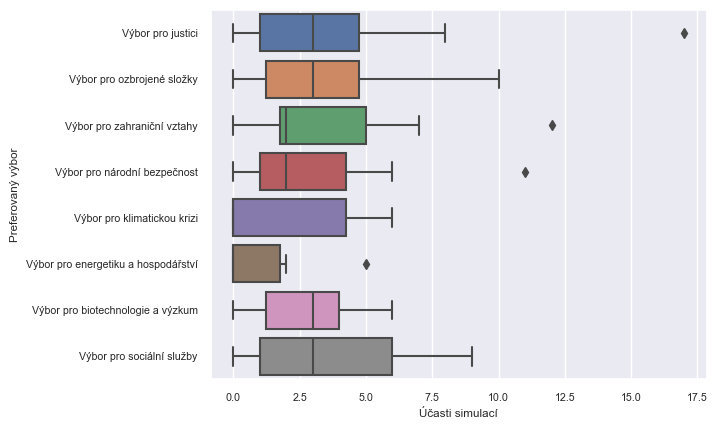

In [42]:
sns.boxplot(data=pairedRegs, x=pairedRegs['Účasti simulací'], y=pairedRegs['Preferovaný výbor'], orient="h")

In [43]:
lobbyOrgs = ['CCTV America (China Central Television)', 'Honeywell',
       'ConocoPhillips', 'General Electric', 'AT&T', 'Lockeheed Martin',
       'Cargill', 'Human Rights Watch', 'Greenpeace',
       'Union of Concerned Scientists',
       'Rural Community Assistance Partnership',
       'American Bar Association', 'Hudson Institute', 'Cato Institute',
       'RAND Corporation', 'Heritage Foundation',
       'Bill & Melinda Gates Foundation', 'Strategic Organizing Center',
       'Utility Workers Union of America (UWUA)']
parties = ['Republikánská strana','Demokratická strana']
fractions = ['Modří psi', 'Noví demokraté', 'Progresivisté', 'Nová pravice', 'Liberální republikáni', 'Klub za svobodu']
interestFractions = ['Mezistranický klub poslankyň', 'Uskupení pro pokročilé jaderné technologie', 'Uskupení pro oblast ASEAN',
                     'Uskupení pro ropu a zemní plyn', 'Koalice za udržitelnou energetiku a životní prostředí',
                     'Uskupení pro moderní technologie', 'Spolek pro otázky domorodých američanů', 'Uskupení pro zemědělský výzkum',
                     'Klub sněmovních afroameričanů', 'Anti-woke spolek']
news = ['CNN', 'Fox News']
fees = ['Účet federální vlády']
democraticFractions = ['Modří psi', 'Noví demokraté', 'Progresivisté']
republicanFractions = ['Nová pravice', 'Liberální republikáni', 'Klub za svobodu']

In [44]:
pairedTrans = constructTransactionsWithUserAndRegFields(users=nonOrgs, registrations=registrations, transactions=transactions)
pairedTrans = pairedTrans[pairedTrans['Částka'] < 4000000]

In [45]:
def sumAmountsByCategories(categories: list, categoricalField: str, data: pd.DataFrame, transactionPart='Příjemce') -> pd.DataFrame:
    amounts = []
    for i in categories:
        found = data[data[categoricalField] == i]
        amounts.append(found['Částka'].sum())
    return pd.DataFrame({categoricalField: categories, 
                                'Částka': amounts})

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2950815902.py:3: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



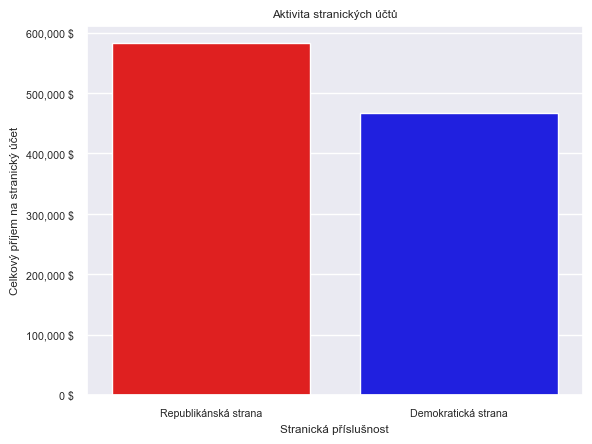

In [46]:
partisianTrans = sumAmountsByCategories(parties, 'Příjemce', pairedTrans)
fig = sns.barplot(x=partisianTrans['Příjemce'], y=partisianTrans['Částka'], data=partisianTrans, palette=['Red', 'Blue'])
fig.set_yticklabels(['{:,.0f}'.format(x) + ' $' for x in fig.get_yticks()])
plt.ylabel("Celkový příjem na stranický účet")
plt.xlabel("Stranická příslušnost")
plt.title("Aktivita stranických účtů")
plt.show(fig)

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\478600849.py:3: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



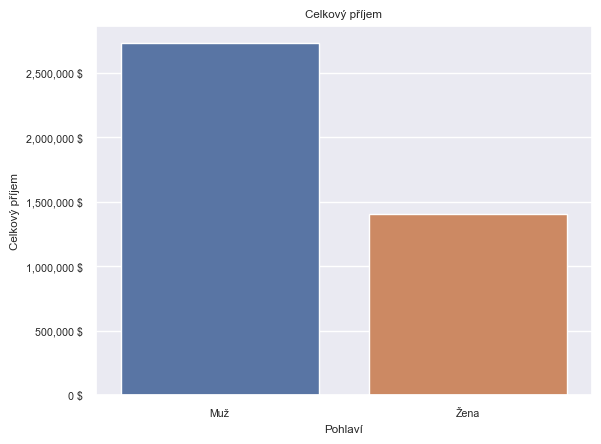

In [47]:
genderTrans = sumAmountsByCategories(['Muž', 'Žena'], 'Pohlaví příjemce', pairedTrans)
fig = sns.barplot(x=genderTrans['Pohlaví příjemce'], y=genderTrans['Částka'], data=genderTrans)
fig.set_yticklabels(['{:,.0f}'.format(x) + ' $' for x in fig.get_yticks()])
plt.ylabel("Celkový příjem")
plt.xlabel("Pohlaví")
plt.title("Celkový příjem")
plt.show(fig)

In [48]:
genderTrans.loc[1, 'Částka'] /= len(users[users['Pohlaví'] == 'Žena'])
genderTrans.loc[0, 'Částka'] /= len(users[users['Pohlaví'] == 'Muž'])

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2216323815.py:2: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



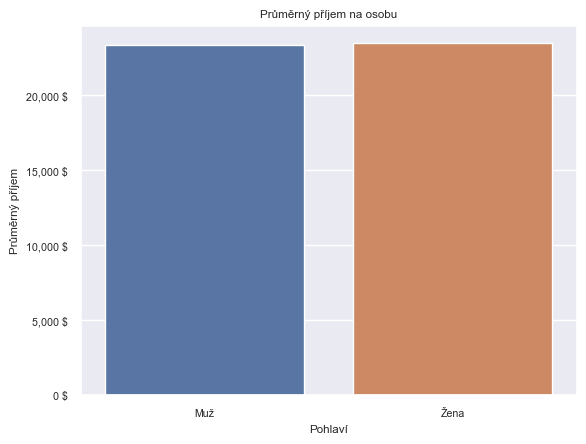

In [49]:
fig = sns.barplot(x=genderTrans['Pohlaví příjemce'], y=genderTrans['Částka'], data=genderTrans)
fig.set_yticklabels(['{:,.0f}'.format(x) + ' $' for x in fig.get_yticks()])
plt.ylabel("Průměrný příjem")
plt.xlabel("Pohlaví")
plt.title('Průměrný příjem na osobu')
plt.show(fig)

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\794391805.py:3: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



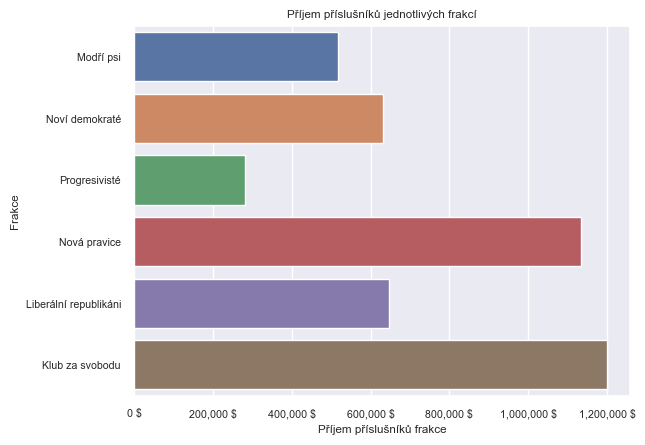

In [50]:
fractionIndividualTrans = sumAmountsByCategories(fractions, 'Frakce příjemce', pairedTrans)
fig = sns.barplot(y=fractionIndividualTrans['Frakce příjemce'], x=fractionIndividualTrans['Částka'], data=fractionIndividualTrans)
fig.set_xticklabels(['{:,.0f}'.format(x) + ' $' for x in fig.get_xticks()])
plt.ylabel("Frakce")
plt.xlabel("Příjem příslušníků frakce")
plt.title("Příjem příslušníků jednotlivých frakcí")
plt.show(fig)

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\1547837056.py:3: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



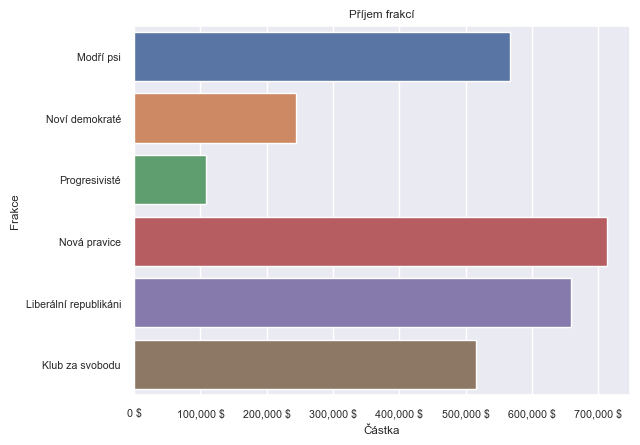

In [51]:
fractionTrans = sumAmountsByCategories(fractions, 'Příjemce', pairedTrans[pairedTrans['Příjemce'].isin(fractions)])
fig = sns.barplot(y=fractionTrans['Příjemce'], x=fractionTrans['Částka'], data=fractionTrans)
fig.set_xticklabels(['{:,.0f}'.format(x) + ' $' for x in fig.get_xticks()])
plt.ylabel("Frakce")
plt.title("Příjem frakcí")
plt.show(fig)

In [52]:
partisianAccounts = pairedTrans[pairedTrans['Příjemce'].isin(parties)]
fractionalAccounts = pairedTrans[pairedTrans['Příjemce'].isin(fractions)]
maleAccounts = pairedTrans[pairedTrans['Pohlaví příjemce'] == 'Muž']
femaleAccounts = pairedTrans[pairedTrans['Pohlaví příjemce'] == 'Žena']

In [53]:
partitionedIncome = pd.DataFrame({
    'Strany': ['Republikáni', 'Demokraté'],
    'Stranické účty': [partisianAccounts[partisianAccounts['Příjemce'] == 'Republikánská strana']['Částka'].sum(),
                       partisianAccounts[partisianAccounts['Příjemce'] == 'Demokratická strana']['Částka'].sum()],
    'Frakce': [fractionalAccounts[fractionalAccounts['Příjemce'].isin(republicanFractions)]['Částka'].sum(), 
               fractionalAccounts[fractionalAccounts['Příjemce'].isin(democraticFractions)]['Částka'].sum()],
    'Muži': [maleAccounts[maleAccounts['Strana příjemce'] == 'Republican']['Částka'].sum(), 
             maleAccounts[maleAccounts['Strana příjemce'] == 'Democrat']['Částka'].sum()],
    'Ženy': [femaleAccounts[femaleAccounts['Strana příjemce'] == 'Republican']['Částka'].sum(), 
             femaleAccounts[femaleAccounts['Strana příjemce'] == 'Democrat']['Částka'].sum()]
})

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\1972644864.py:16: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



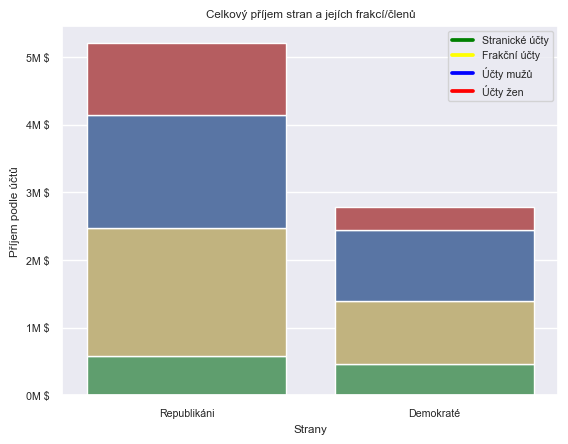

In [54]:
ax = plt.subplots()
 
# plotting columns
ax = sns.barplot(x=partitionedIncome["Strany"], y=partitionedIncome["Stranické účty"], color='g')
ax = sns.barplot(x=partitionedIncome["Strany"], y=partitionedIncome["Frakce"], bottom=partitionedIncome["Stranické účty"], color='y')
ax = sns.barplot(x=partitionedIncome["Strany"], y=partitionedIncome["Muži"], bottom=partitionedIncome["Stranické účty"] + partitionedIncome["Frakce"], color='b')
ax = sns.barplot(x=partitionedIncome["Strany"], y=partitionedIncome["Ženy"], 
                 bottom=partitionedIncome["Stranické účty"] + partitionedIncome["Frakce"] + partitionedIncome["Muži"], color='r')
 
# visualizing illustration
leg = plt.legend(["Stranické účty", "Frakční účty", "Účty mužů", "Účty žen"])
leg.legend_handles[0].set_color('green')
leg.legend_handles[1].set_color('yellow')
leg.legend_handles[2].set_color('blue')
leg.legend_handles[3].set_color('red')
ax.set_yticklabels(['{:,.0f}'.format(x) + 'M $' for x in fig.get_yticks()])
plt.ylabel("Příjem podle účtů")
plt.title("Celkový příjem stran a jejích frakcí/členů")
plt.show()

In [55]:
averagedIncome = pd.DataFrame({
    'Strany': ['Republikáni', 'Demokraté'],
    'Stranické účty': [partisianAccounts[partisianAccounts['Příjemce'] == 'Republikánská strana']['Částka'].mean(),
                       partisianAccounts[partisianAccounts['Příjemce'] == 'Demokratická strana']['Částka'].mean()],
    'Frakce': [fractionalAccounts[fractionalAccounts['Příjemce'].isin(republicanFractions)]['Částka'].mean(), 
               fractionalAccounts[fractionalAccounts['Příjemce'].isin(democraticFractions)]['Částka'].mean()],
    'Muži': [maleAccounts[maleAccounts['Strana příjemce'] == 'Republican']['Částka'].mean(), 
             maleAccounts[maleAccounts['Strana příjemce'] == 'Democrat']['Částka'].mean()],
    'Ženy': [femaleAccounts[femaleAccounts['Strana příjemce'] == 'Republican']['Částka'].mean(), 
             femaleAccounts[femaleAccounts['Strana příjemce'] == 'Democrat']['Částka'].mean()]
})

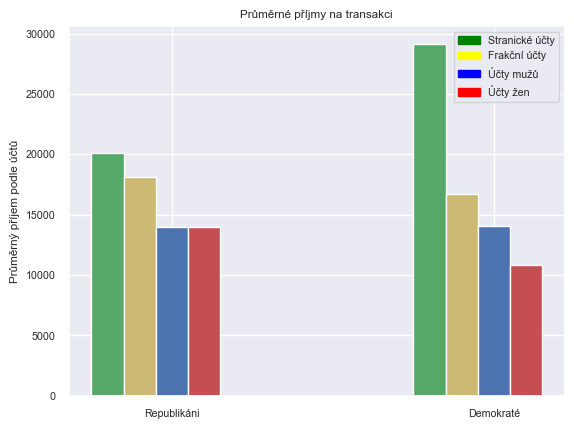

In [56]:
ax = plt.subplots()

X_axis = np.arange(2)
# plotting columns
ax = plt.bar(x=X_axis - 0.2, height=averagedIncome["Stranické účty"], width=0.1, color='g')
ax = plt.bar(x=X_axis - 0.1, height=averagedIncome["Frakce"], width=0.1, color='y')
ax = plt.bar(x=X_axis, height=averagedIncome["Muži"], width=0.1, color='b')
ax = plt.bar(x=X_axis + 0.1, height=averagedIncome["Ženy"], width=0.1, color='r')
 
# visualizing illustration
leg = plt.legend(["Stranické účty", "Frakční účty", "Účty mužů", "Účty žen"])
leg.legend_handles[0].set_color('green')
leg.legend_handles[1].set_color('yellow')
leg.legend_handles[2].set_color('blue')
leg.legend_handles[3].set_color('red')
plt.ylabel("Průměrný příjem podle účtů")
plt.xticks(X_axis, averagedIncome["Strany"])
plt.title("Průměrné příjmy na transakci")
plt.show()

In [57]:
houseAccounts = pairedTrans[pairedTrans['Typ pozice příjemce'] == 'House']
senateAccounts = pairedTrans[pairedTrans['Typ pozice příjemce'] == 'Senate']

In [58]:
partitionedIncome = pd.DataFrame({
    'Strany': ['Republikáni', 'Demokraté'],
    'Sněmovna': [houseAccounts[houseAccounts['Strana příjemce'] == 'Republican']['Částka'].sum(), 
             houseAccounts[houseAccounts['Strana příjemce'] == 'Democrat']['Částka'].sum()],
    'Senát': [senateAccounts[senateAccounts['Strana příjemce'] == 'Republican']['Částka'].sum(), 
             senateAccounts[senateAccounts['Strana příjemce'] == 'Democrat']['Částka'].sum()]
})

In [59]:
partitionedIncome

,Strany,Sněmovna,Senát
0,Republikáni,1945511.0,1034571.0
1,Demokraté,871171.5,560999.0


C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2874543946.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



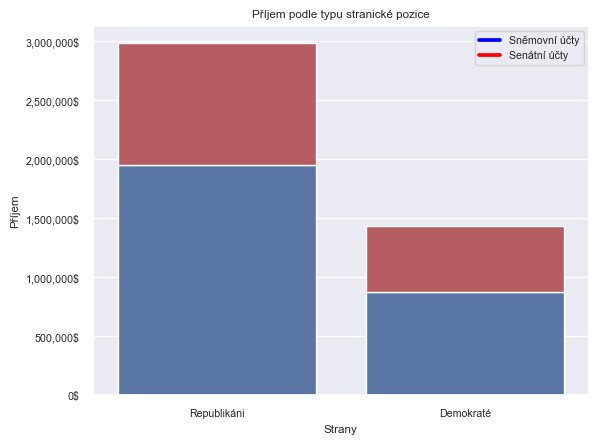

In [60]:
ax = plt.subplots()
 
# plotting columns
ax = sns.barplot(x=partitionedIncome["Strany"], y=partitionedIncome["Sněmovna"], color='b')
ax = sns.barplot(x=partitionedIncome["Strany"], y=partitionedIncome["Senát"], bottom=partitionedIncome["Sněmovna"], color='r')
 
# visualizing illustration
leg = plt.legend(["Sněmovní účty", "Senátní účty"])
leg.legend_handles[0].set_color('blue')
leg.legend_handles[1].set_color('red')
ax.set_yticklabels(['{:,.0f}'.format(x) + '$' for x in ax.get_yticks()])
plt.ylabel("Příjem")
plt.title("Příjem podle typu stranické pozice")
plt.show()

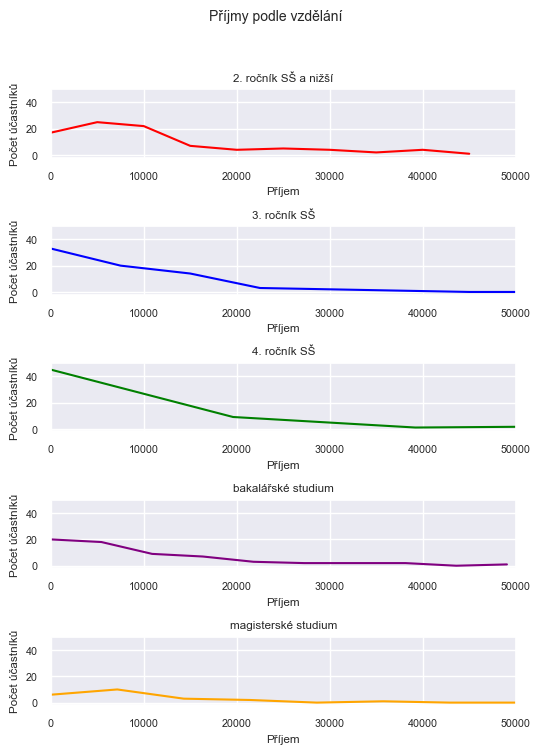

In [61]:
fig, ax = plt.subplots(5, 1, figsize=(6, 8))
fig.subplots_adjust(hspace=1, wspace=0.4)
fig.suptitle('Příjmy podle vzdělání')
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in range(len(schoolVals)):
    current = pairedTrans[pairedTrans['Vzdělání příjemce'] == schoolVals[i]]
    am_hist = np.histogram(current['Částka'])
    p = sns.lineplot(x=am_hist[1][:-1], y=am_hist[0], ax=ax[i], color=colors[i])
    p.set(ylim=(-2, 50))
    p.set(xlim=(0, 50000))
    p.set(title=schoolVals[i])
    p.set(ylabel="Počet účastníků")
    p.set(xlabel="Příjem")

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\1463071495.py:3: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



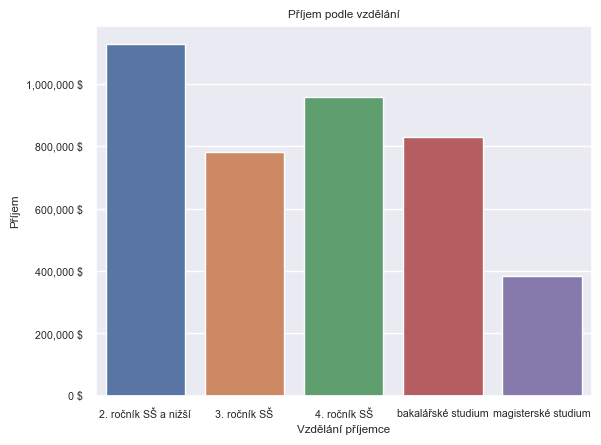

In [62]:
schoolTrans = sumAmountsByCategories(schoolVals, 'Vzdělání příjemce', pairedTrans[pairedTrans['Vzdělání příjemce'].isin(schoolVals)])
fig = sns.barplot(x=schoolTrans['Vzdělání příjemce'], y=schoolTrans['Částka'], data=schoolTrans)
fig.set_yticklabels(['{:,.0f}'.format(x) + ' $' for x in fig.get_yticks()])
plt.ylabel("Příjem")
plt.title("Příjem podle vzdělání")
plt.show(fig)

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\1028069898.py:4: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



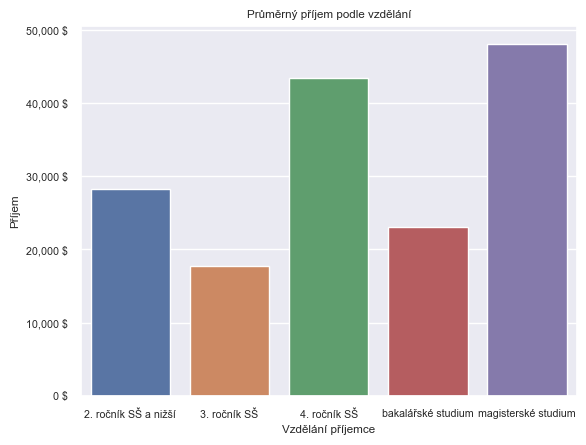

In [63]:
for i in schoolTrans.index:
    schoolTrans.loc[i, 'Částka'] /= len(accepted[accepted['Školní rok'] == schoolTrans.at[i, 'Vzdělání příjemce']])
fig = sns.barplot(x=schoolTrans['Vzdělání příjemce'], y=schoolTrans['Částka'], data=schoolTrans)
fig.set_yticklabels(['{:,.0f}'.format(x) + ' $' for x in fig.get_yticks()])
plt.ylabel("Příjem")
plt.title("Průměrný příjem podle vzdělání")
plt.show(fig)

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\1242989127.py:3: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



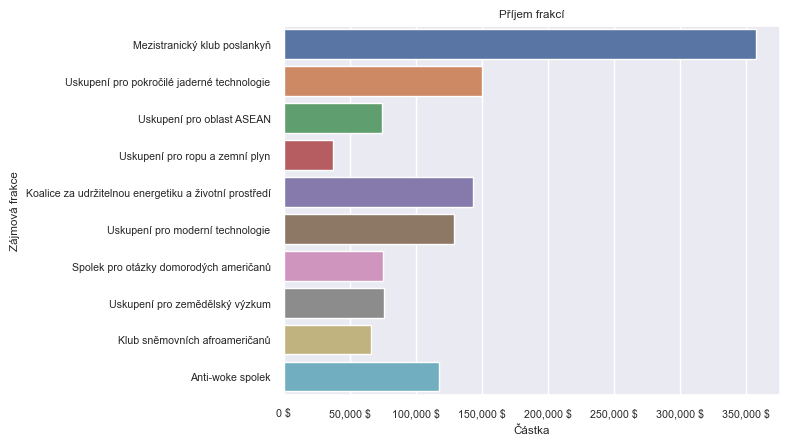

In [64]:
fractionTrans = sumAmountsByCategories(interestFractions, 'Příjemce', pairedTrans[pairedTrans['Příjemce'].isin(interestFractions)])
fig = sns.barplot(y=fractionTrans['Příjemce'], x=fractionTrans['Částka'], data=fractionTrans)
fig.set_xticklabels(['{:,.0f}'.format(x) + ' $' for x in fig.get_xticks()])
plt.ylabel("Zájmová frakce")
plt.title("Příjem frakcí")
plt.show(fig)

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2725466758.py:3: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



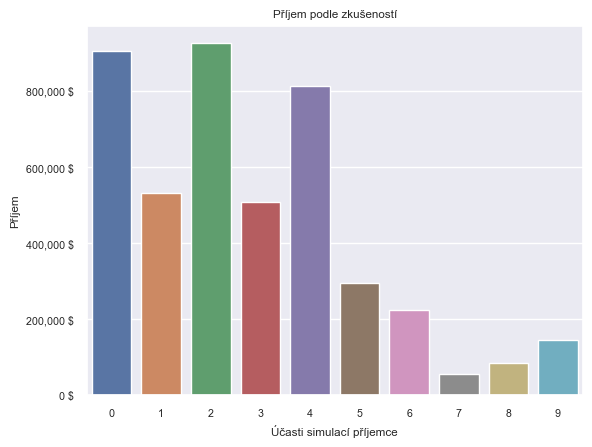

In [65]:
experienceTrans = sumAmountsByCategories(pairedTrans['Účasti simulací příjemce'].unique(), 'Účasti simulací příjemce', pairedTrans[pairedTrans['Účasti simulací příjemce'].isin(pairedTrans['Účasti simulací příjemce'].unique())])
fig = sns.barplot(x=experienceTrans['Účasti simulací příjemce'], y=experienceTrans['Částka'], data=experienceTrans[1:])
fig.set_yticklabels(['{:,.0f}'.format(x) + ' $' for x in fig.get_yticks()])
fig.set_xticklabels(['{:,.0f}'.format(x) for x in fig.get_xticks()])
plt.ylabel("Příjem")
plt.title("Příjem podle zkušeností")
plt.show(fig)

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\3135988547.py:2: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\3135988547.py:4: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



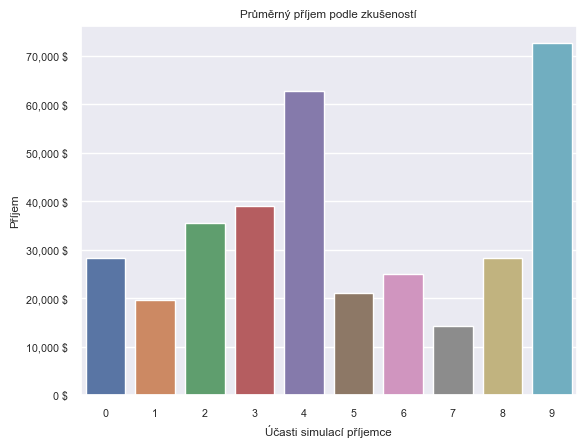

In [66]:
for i in experienceTrans.index:
    experienceTrans.loc[i, 'Částka'] /= len(accepted[accepted['Účasti simulací'] == experienceTrans.at[i, 'Účasti simulací příjemce']])
fig = sns.barplot(x=experienceTrans['Účasti simulací příjemce'], y=experienceTrans['Částka'], data=experienceTrans[1:])
fig.set_yticklabels(['{:,.0f}'.format(x) + ' $' for x in fig.get_yticks()])
fig.set_xticklabels(['{:,.0f}'.format(x) for x in fig.get_xticks()])
plt.ylabel("Příjem")
plt.title("Průměrný příjem podle zkušeností")
plt.show(fig)

In [67]:
partisianAccounts = pairedTrans[pairedTrans['Odesílatel'].isin(parties)]
fractionalAccounts = pairedTrans[pairedTrans['Odesílatel'].isin(fractions)]

In [68]:
partitionedOutput = pd.DataFrame({
    'Strany': ['Republikáni', 'Demokraté'],
    'Stranické účty': [partisianAccounts[partisianAccounts['Odesílatel'] == 'Republikánská strana']['Částka'].sum(),
                       partisianAccounts[partisianAccounts['Odesílatel'] == 'Demokratická strana']['Částka'].sum()],
    'Frakce': [fractionalAccounts[fractionalAccounts['Odesílatel'].isin(republicanFractions)]['Částka'].sum(), 
               fractionalAccounts[fractionalAccounts['Odesílatel'].isin(democraticFractions)]['Částka'].sum()]
})

In [70]:
partitionedIncome

,Strany,Stranické účty,Frakce
0,Republikáni,470000.0,1481500.0
1,Demokraté,310002.0,639250.0


C:\Users\margr\AppData\Local\Temp\ipykernel_17940\631582407.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



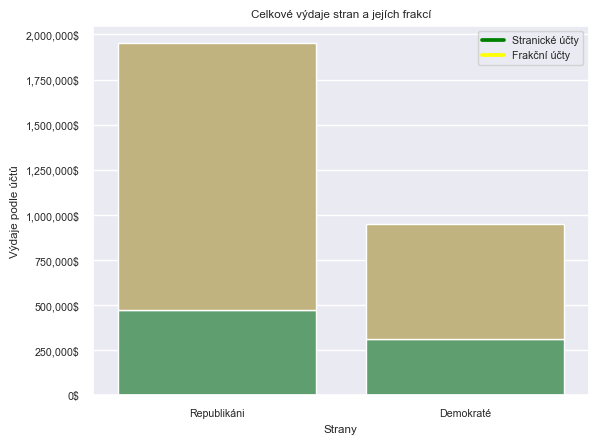

In [74]:
ax = plt.subplots()
 
# plotting columns
ax = sns.barplot(x=partitionedOutput["Strany"], y=partitionedOutput["Stranické účty"], color='g')
ax = sns.barplot(x=partitionedOutput["Strany"], y=partitionedOutput["Frakce"], bottom=partitionedOutput["Stranické účty"], color='y')
 
# visualizing illustration
leg = plt.legend(["Stranické účty", "Frakční účty"])
leg.legend_handles[0].set_color('green')
leg.legend_handles[1].set_color('yellow')
ax.set_yticklabels(['{:,.0f}'.format(x) + '$' for x in ax.get_yticks()])
plt.ylabel("Výdaje podle účtů")
plt.title("Celkové výdaje stran a jejích frakcí")
plt.show()

In [75]:
democraticPartyAccount = pairedTrans[pairedTrans['Příjemce'] == 'Demokratická strana']
republicanPartyAccount = pairedTrans[pairedTrans['Příjemce'] == 'Republikánská strana']
democraticFractionalAccounts = pairedTrans[pairedTrans['Příjemce'].isin(democraticFractions)]
republicanFractionalAccounts = pairedTrans[pairedTrans['Příjemce'].isin(republicanFractions)]
democraticPersonalAccounts = pairedTrans[pairedTrans['Strana příjemce'] == 'Democrat']
republicanPersonalAccounts = pairedTrans[pairedTrans['Strana příjemce'] == 'Republican']

In [76]:
partitionedLobbyOutput = pd.DataFrame({
    'Strany': ['Republikáni', 'Demokraté'],
    'Stranický příjem z lobby': [republicanPartyAccount[republicanPartyAccount['Odesílatel'].isin(lobbyOrgs)]['Částka'].sum(),
                       democraticPartyAccount[democraticPartyAccount['Odesílatel'].isin(lobbyOrgs)]['Částka'].sum()],
    'Frakční příjem z lobby': [republicanFractionalAccounts[republicanFractionalAccounts['Odesílatel'].isin(lobbyOrgs)]['Částka'].sum(), 
               democraticFractionalAccounts[democraticFractionalAccounts['Odesílatel'].isin(lobbyOrgs)]['Částka'].sum()],
    'Osobní příjem z lobby': [republicanPersonalAccounts[republicanPersonalAccounts['Odesílatel'].isin(lobbyOrgs)]['Částka'].sum(), 
               democraticPersonalAccounts[democraticPersonalAccounts['Odesílatel'].isin(lobbyOrgs)]['Částka'].sum()]
})

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\2684087737.py:15: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



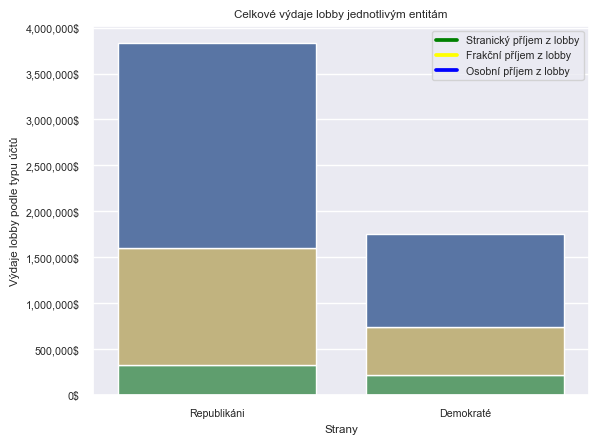

In [77]:
ax = plt.subplots()
 
# plotting columns
ax = sns.barplot(x=partitionedLobbyOutput["Strany"], y=partitionedLobbyOutput['Stranický příjem z lobby'], color='g')
ax = sns.barplot(x=partitionedLobbyOutput["Strany"], y=partitionedLobbyOutput['Frakční příjem z lobby'], 
                 bottom=partitionedLobbyOutput['Stranický příjem z lobby'], color='y')
ax = sns.barplot(x=partitionedLobbyOutput["Strany"], y=partitionedLobbyOutput['Osobní příjem z lobby'], 
                 bottom=partitionedLobbyOutput['Stranický příjem z lobby'] + partitionedLobbyOutput['Frakční příjem z lobby'], color='b')
 
# visualizing illustration
leg = plt.legend(['Stranický příjem z lobby', 'Frakční příjem z lobby', 'Osobní příjem z lobby'])
leg.legend_handles[0].set_color('green')
leg.legend_handles[1].set_color('yellow')
leg.legend_handles[2].set_color('blue')
ax.set_yticklabels(['{:,.0f}'.format(x) + '$' for x in ax.get_yticks()])
plt.ylabel("Výdaje lobby podle typu účtů")
plt.title("Celkové výdaje lobby jednotlivým entitám")
plt.show()

In [81]:
democraticPersonalAccounts = pairedTrans[pairedTrans['Strana příjemce'] == 'Democrat']
republicanPersonalAccounts = pairedTrans[pairedTrans['Strana příjemce'] == 'Republican']

In [86]:
partitionedPersonalIncome = pd.DataFrame({
    'Strany': ['Republikáni', 'Demokraté'],
    'Osobní příjem z lobby': [republicanPersonalAccounts[republicanPersonalAccounts['Odesílatel'].isin(lobbyOrgs)]['Částka'].sum(), 
               democraticPersonalAccounts[democraticPersonalAccounts['Odesílatel'].isin(lobbyOrgs)]['Částka'].sum()],
    'Osobní příjem ze stranických účtů': [republicanPersonalAccounts[republicanPersonalAccounts['Odesílatel'].isin(parties)]['Částka'].sum(), 
               democraticPersonalAccounts[democraticPersonalAccounts['Odesílatel'].isin(parties)]['Částka'].sum()],
    'Osobní příjem z frakčních účtů': [republicanPersonalAccounts[republicanPersonalAccounts['Odesílatel'].isin(fractions)]['Částka'].sum(), 
               democraticPersonalAccounts[democraticPersonalAccounts['Odesílatel'].isin(fractions)]['Částka'].sum()],
    'Osobní příjem z účtů zájmových frakcí': [republicanPersonalAccounts[republicanPersonalAccounts['Odesílatel'].isin(interestFractions)]['Částka'].sum(), 
               democraticPersonalAccounts[democraticPersonalAccounts['Odesílatel'].isin(interestFractions)]['Částka'].sum()]
})

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\677834622.py:20: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



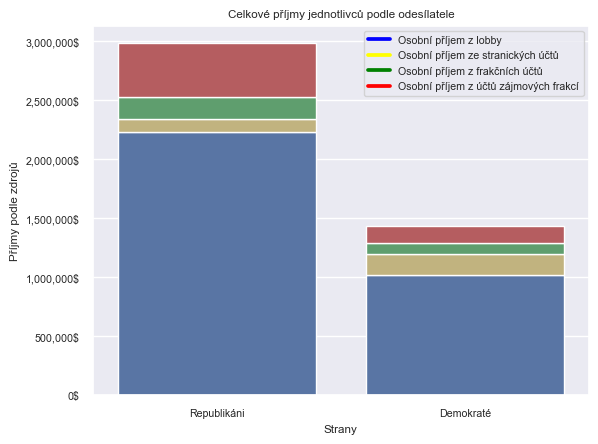

In [88]:
ax = plt.subplots()
 
# plotting columns
ax = sns.barplot(x=partitionedPersonalIncome["Strany"], y=partitionedPersonalIncome['Osobní příjem z lobby'], color='b')
ax = sns.barplot(x=partitionedPersonalIncome["Strany"], y=partitionedPersonalIncome['Osobní příjem ze stranických účtů'], 
                 bottom=partitionedLobbyOutput['Osobní příjem z lobby'], color='y')
ax = sns.barplot(x=partitionedPersonalIncome["Strany"], y=partitionedPersonalIncome['Osobní příjem z frakčních účtů'], 
                 bottom=partitionedLobbyOutput['Osobní příjem z lobby'] + partitionedPersonalIncome['Osobní příjem ze stranických účtů'], color='g')
ax = sns.barplot(x=partitionedPersonalIncome["Strany"], y=partitionedPersonalIncome['Osobní příjem z účtů zájmových frakcí'], 
                 bottom=partitionedLobbyOutput['Osobní příjem z lobby'] 
                 + partitionedPersonalIncome['Osobní příjem ze stranických účtů']
                 + partitionedPersonalIncome['Osobní příjem z frakčních účtů'], color='r')
 
# visualizing illustration
leg = plt.legend(['Osobní příjem z lobby', 'Osobní příjem ze stranických účtů', 'Osobní příjem z frakčních účtů', 'Osobní příjem z účtů zájmových frakcí'])
leg.legend_handles[0].set_color('blue')
leg.legend_handles[1].set_color('yellow')
leg.legend_handles[2].set_color('green')
leg.legend_handles[3].set_color('red')
ax.set_yticklabels(['{:,.0f}'.format(x) + '$' for x in ax.get_yticks()])
plt.ylabel("Příjmy podle zdrojů")
plt.title("Celkové příjmy jednotlivců podle odesílatele")
plt.show()

C:\Users\margr\AppData\Local\Temp\ipykernel_17940\3484397646.py:3: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



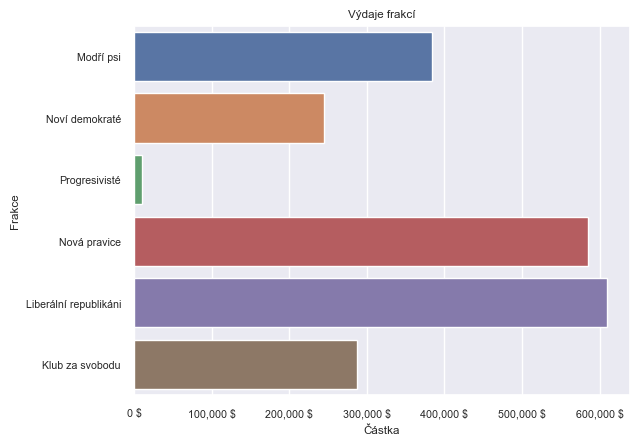

In [89]:
fractionTrans = sumAmountsByCategories(fractions, 'Odesílatel', pairedTrans[pairedTrans['Odesílatel'].isin(fractions)])
fig = sns.barplot(y=fractionTrans['Odesílatel'], x=fractionTrans['Částka'], data=fractionTrans)
fig.set_xticklabels(['{:,.0f}'.format(x) + ' $' for x in fig.get_xticks()])
plt.ylabel("Frakce")
plt.title("Výdaje frakcí")
plt.show(fig)